In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Plant_Dataset/plant_diseases_data.zip

Streaming output truncated to the last 5000 lines.
  inflating: plant_diseases_data/wheat/train/Brown rust/Brown_rust513.jpg  
  inflating: plant_diseases_data/wheat/train/Brown rust/Brown_rust515.jpg  
  inflating: plant_diseases_data/wheat/train/Brown rust/Brown_rust516.jpg  
  inflating: plant_diseases_data/wheat/train/Brown rust/Brown_rust517.jpg  
  inflating: plant_diseases_data/wheat/train/Brown rust/Brown_rust519.jpg  
  inflating: plant_diseases_data/wheat/train/Brown rust/Brown_rust520.jpg  
  inflating: plant_diseases_data/wheat/train/Brown rust/Brown_rust521.jpg  
  inflating: plant_diseases_data/wheat/train/Brown rust/Brown_rust523.jpg  
  inflating: plant_diseases_data/wheat/train/Brown rust/Brown_rust524.jpg  
  inflating: plant_diseases_data/wheat/train/Brown rust/Brown_rust526.jpg  
  inflating: plant_diseases_data/wheat/train/Brown rust/Brown_rust528.jpg  
  inflating: plant_diseases_data/wheat/train/Brown rust/Brown_rust530.jpg  
  inflating: plant_diseases_data/whea

In [ ]:
print(len(os.listdir('/content/plant_diseases_data/bean/train/angular_leaf_spot')) + len(os.listdir('/content/plant_diseases_data/bean/train/bean_rust')) + len(os.listdir('/content/plant_diseases_data/bean/train/healthy')) )
print(len(os.listdir('/content/plant_diseases_data/rice/train/Bacterial leaf blight')) + len(os.listdir('/content/plant_diseases_data/rice/train/Bacterial leaf blight')) + len(os.listdir('/content/plant_diseases_data/rice/train/Brown spot')) + len(os.listdir('/content/plant_diseases_data/rice/train/Leaf smut')))
print(len(os.listdir('/content/plant_diseases_data/wheat/train/Brown rust')) + len(os.listdir('/content/plant_diseases_data/wheat/train/Healthy')) + len(os.listdir('/content/plant_diseases_data/wheat/train/Loose Smut')) + len(os.listdir('/content/plant_diseases_data/wheat/train/Yellow Rust')) + len(os.listdir('/content/plant_diseases_data/wheat/train/Septoria')) )
print(len(os.listdir('/content/plant_diseases_data/bean/val/angular_leaf_spot')) + len(os.listdir('/content/plant_diseases_data/bean/val/bean_rust')) + len(os.listdir('/content/plant_diseases_data/bean/val/healthy')) )
print(len(os.listdir('/content/plant_diseases_data/rice/train/Bacterial leaf blight')) + len(os.listdir('/content/plant_diseases_data/rice/val/Bacterial leaf blight')) + len(os.listdir('/content/plant_diseases_data/rice/val/Brown spot')) + len(os.listdir('/content/plant_diseases_data/rice/val/Leaf smut')))
print(len(os.listdir('/content/plant_diseases_data/wheat/val/Brown rust')) + len(os.listdir('/content/plant_diseases_data/wheat/val/Healthy')) + len(os.listdir('/content/plant_diseases_data/wheat/val/Loose Smut')) + len(os.listdir('/content/plant_diseases_data/wheat/val/Yellow Rust')) + len(os.listdir('/content/plant_diseases_data/wheat/val/Septoria')) )

1034
128
4476
133
56
1121


In [ ]:
!pip install tensorflow
!pip install keras
!pip install scikit-learn

In [ ]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image

# Function to remove corrupted images before training
def remove_corrupted_images(image_paths):
    valid_image_paths = []
    for img_path in image_paths:
        try:
            img = Image.open(img_path)
            img.verify()  # Verify the image file
            valid_image_paths.append(img_path)  # If valid, add to the list
        except (IOError, SyntaxError) as e:
            print(f"Corrupted image found and removed: {img_path}")
            os.remove(img_path)  # Remove the corrupted image from the filesystem
    return valid_image_paths

# Function to create a data generator using the tf.data API
def create_tf_data_generator(image_paths, labels, batch_size=32, is_training=True):
    def process_image(img_path, label):
        try:
            img = tf.io.read_file(img_path)
            img = tf.image.decode_image(img, channels=3)
            img = tf.image.resize(img, [150, 150])  # Resize to target dimensions
            img = img / 255.0  # Normalize image pixels
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")
            img = tf.zeros((150, 150, 3))  # Return a blank image if error occurs
        return img, tf.one_hot(label, depth=len(set(labels)))

    # Create a dataset of image paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    # Process the images and labels
    dataset = dataset.map(lambda img_path, label: process_image(img_path, label),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Shuffle, batch, and prefetch the dataset
    if is_training:
        dataset = dataset.shuffle(len(image_paths)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    else:
        dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

CNN Model

In [ ]:
import tensorflow as tf

def build_combined_model(num_classes):
    model = tf.keras.Sequential([
        # Convolutional layers
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),

        # Flattening the 3D output of Conv layers to 1D
        tf.keras.layers.Flatten(),

        # Fully connected (Dense) layers
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),  # Dropout for regularization

        tf.keras.layers.Dense(128, activation='relu'),

        # Output layer for multi-class classification
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    return model

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_image_paths_and_labels(plant, base_dir):
    image_paths = []
    labels = []
    class_names = []  # A list to keep track of class (disease) names

    # Define the directory for the current plant's training data
    plant_train_dir = os.path.join(base_dir, plant, 'train')

    # Iterate through each class (disease folder) in the training directory
    for class_name in os.listdir(plant_train_dir):
        class_dir = os.path.join(plant_train_dir, class_name)

        if os.path.isdir(class_dir):  # Ensure it's a directory
            if class_name not in class_names:
                class_names.append(class_name)  # Add class name (disease) to the list of classes

            # Get all image paths for the current class
            for img_file in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_file)

                if os.path.isfile(img_path):
                    image_paths.append(img_path)
                    labels.append(class_names.index(class_name))  # Assign label as index of class_name

    num_classes = len(class_names)  # Number of unique classes

    return image_paths, labels, num_classes

In [ ]:
!pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 48.0 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

plants = ['bean', 'rice', 'wheat']
base_dir = '/content/plant_diseases_data/'

for plant in plants:
    print(f'Preparing model for {plant}...')

    # Get image paths, labels, and number of classes
    image_paths, labels, num_classes = get_image_paths_and_labels(plant, base_dir)

    # Remove corrupted images from the dataset
    valid_image_paths = remove_corrupted_images(image_paths)

    # Initialize K-Fold cross-validator
    kf = KFold(n_splits=4, shuffle=True, random_state=42)
    fold_no = 1

    for train_index, val_index in kf.split(valid_image_paths):
        print(f'Training Fold {fold_no} for {plant}...')

        # Split the dataset into training and validation sets
        train_image_paths = np.array(valid_image_paths)[train_index]
        train_labels = np.array(labels)[train_index]
        val_image_paths = np.array(valid_image_paths)[val_index]
        val_labels = np.array(labels)[val_index]

        # Create tf.data datasets
        train_dataset = create_tf_data_generator(train_image_paths, train_labels, is_training=True)
        val_dataset = create_tf_data_generator(val_image_paths, val_labels, is_training=False)

        # Build and compile the model
        model = build_combined_model(num_classes)
        model.compile(
            loss='categorical_crossentropy',
            optimizer=tf.keras.optimizers.Adam(),
            metrics=['accuracy']
        )

        # Train the model
        model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=20
        )

        # Evaluate the model on the validation set
        val_predictions = model.predict(val_dataset)
        y_pred = np.argmax(val_predictions, axis=1)
        y_true = np.concatenate([np.argmax(batch[1], axis=1) for batch in val_dataset], axis=0)

        # Calculate precision, recall, f1-score, and accuracy
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')
        accuracy = accuracy_score(y_true, y_pred)

        # Print the metrics for the current fold
        print(f'{plant} - Fold {fold_no} Metrics:')
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'F1-score: {f1:.4f}')
        print(f'Accuracy: {accuracy:.4f}')

        fold_no += 1

Preparing model for bean...
Training Fold 1 for bean...
Error processing image Tensor("args_0:0", shape=(), dtype=string): 'images' contains no shape.
Error processing image Tensor("args_0:0", shape=(), dtype=string): 'images' contains no shape.
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 227ms/step - accuracy: 0.3593 - loss: 1.0987 - val_accuracy: 0.3436 - val_loss: 1.0987
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3531 - loss: 1.0985 - val_accuracy: 0.3012 - val_loss: 1.0989
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3435 - loss: 1.0985 - val_accuracy: 0.3012 - val_loss: 1.0992
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3405 - loss: 1.0985 - val_accuracy: 0.3012 - val_loss: 1.0994
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3442 - loss: 1.0984 - val_accuracy: 0.3012 - val_loss: 1.0996
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3560 - loss: 1.0981 - val_accuracy: 0.3012 - val_loss

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - accuracy: 0.3440 - loss: 1.0986 - val_accuracy: 0.2703 - val_loss: 1.0994
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.3665 - loss: 1.0983 - val_accuracy: 0.2703 - val_loss: 1.0999
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3380 - loss: 1.0986 - val_accuracy: 0.2703 - val_loss: 1.1004
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3443 - loss: 1.0984 - val_accuracy: 0.2703 - val_loss: 1.1010
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3356 - loss: 1.0987 - val_accuracy: 0.2703 - val_loss: 1.1012
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3402 - loss: 1.0985 - val_accuracy: 0.2703 - val_loss: 1.1018
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3581 - loss: 1.0977 - val_accuracy: 0.2703 - val_loss: 1.1023
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3652 - loss: 1.0972 - val_accuracy: 0.2703 - val_loss: 1

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 199ms/step - accuracy: 0.3479 - loss: 1.0987 - val_accuracy: 0.2674 - val_loss: 1.0992
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3828 - loss: 1.0982 - val_accuracy: 0.2674 - val_loss: 1.0998
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3251 - loss: 1.0988 - val_accuracy: 0.2674 - val_loss: 1.1003
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3707 - loss: 1.0977 - val_accuracy: 0.2674 - val_loss: 1.1012
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3565 - loss: 1.0979 - val_accuracy: 0.2674 - val_loss: 1.1018
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3519 - loss: 1.0980 - val_accuracy: 0.2674 - val_loss: 1.1024
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3482 - loss: 1.0981 - val_accuracy: 0.2674 - val_loss: 1.1029
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.3568 - loss: 1.0976 - val_accuracy: 0.2674 - val_loss: 1

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.3305 - loss: 1.0987 - val_accuracy: 0.2752 - val_loss: 1.0990
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.3566 - loss: 1.0985 - val_accuracy: 0.2752 - val_loss: 1.0993
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3399 - loss: 1.0985 - val_accuracy: 0.2752 - val_loss: 1.0995
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3584 - loss: 1.0983 - val_accuracy: 0.2752 - val_loss: 1.1000
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3475 - loss: 1.0985 - val_accuracy: 0.2752 - val_loss: 1.1000
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.3598 - loss: 1.0978 - val_accuracy: 0.2752 - val_loss: 1.1003
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.3374 - loss: 1.0986 - val_accuracy: 0.2752 - val_loss: 1.1004
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.3618 - loss: 1.0979 - val_accuracy: 0.2752 - val_loss: 1

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.3299 - loss: 1.0986 - val_accuracy: 0.1667 - val_loss: 1.0993
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3859 - loss: 1.0984 - val_accuracy: 0.1667 - val_loss: 1.0998
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3780 - loss: 1.0983 - val_accuracy: 0.1667 - val_loss: 1.1000
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3937 - loss: 1.0981 - val_accuracy: 0.1667 - val_loss: 1.1003
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3859 - loss: 1.0981 - val_accuracy: 0.1667 - val_loss: 1.1006
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4327 - loss: 1.0975 - val_accuracy: 0.1667 - val_loss: 1.1009
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4015 - loss: 1.0977 - val_accuracy: 0.1667 - val_loss: 1.1012
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3898 - loss: 1.0978 - val_accuracy: 0.1667 - val_loss: 1.1014
Epoch 9/20
3/

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 984ms/step - accuracy: 0.3455 - loss: 1.0987 - val_accuracy: 0.2500 - val_loss: 1.0988
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.3681 - loss: 1.0985 - val_accuracy: 0.2500 - val_loss: 1.0991
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3641 - loss: 1.0985 - val_accuracy: 0.2500 - val_loss: 1.0992
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3563 - loss: 1.0985 - val_accuracy: 0.2500 - val_loss: 1.0993
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3681 - loss: 1.0983 - val_accuracy: 0.2500 - val_loss: 1.0995
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3602 - loss: 1.0983 - val_accuracy: 0.2500 - val_loss: 1.0996
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3602 - loss: 1.0984 - val_accuracy: 0.2500 - val_loss: 1.0998
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3329 - loss: 1.0986 - val_accuracy: 0.2500 - val_loss: 1.1000
Epoch 9/20

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.3867 - loss: 1.0986 - val_accuracy: 0.2083 - val_loss: 1.0993
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3129 - loss: 1.0984 - val_accuracy: 0.2083 - val_loss: 1.0998
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3477 - loss: 1.0983 - val_accuracy: 0.2083 - val_loss: 1.1004
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3906 - loss: 1.0980 - val_accuracy: 0.2083 - val_loss: 1.1010
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3828 - loss: 1.0975 - val_accuracy: 0.2083 - val_loss: 1.1016
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4023 - loss: 1.0978 - val_accuracy: 0.2083 - val_loss: 1.1020
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3672 - loss: 1.0976 - val_accuracy: 0.2083 - val_loss: 1.1026
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3594 - loss: 1.0978 - val_accuracy: 0.2083 - val_loss: 1.1031
Epoch 9/20
3/

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 983ms/step - accuracy: 0.3051 - loss: 1.0986 - val_accuracy: 0.3333 - val_loss: 1.0987
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.2873 - loss: 1.0986 - val_accuracy: 0.3333 - val_loss: 1.0988
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3464 - loss: 1.0984 - val_accuracy: 0.3333 - val_loss: 1.0987
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3464 - loss: 1.0986 - val_accuracy: 0.3333 - val_loss: 1.0987
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3620 - loss: 1.0985 - val_accuracy: 0.3333 - val_loss: 1.0987
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2917 - loss: 1.0988 - val_accuracy: 0.3333 - val_loss: 1.0987
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3346 - loss: 1.0986 - val_accuracy: 0.3333 - val_loss: 1.0987
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2995 - loss: 1.0987 - val_accuracy: 0.3333 - val_loss: 1.0987
Epoch 9/20

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training Fold 1 for wheat...
Error processing image Tensor("args_0:0", shape=(), dtype=string): 'images' contains no shape.
Error processing image Tensor("args_0:0", shape=(), dtype=string): 'images' contains no shape.
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 15s 113ms/step - accuracy: 0.2688 - loss: 1.6024 - val_accuracy: 0.2779 - val_loss: 1.5872
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.3017 - loss: 1.5807 - val_accuracy: 0.2779 - val_loss: 1.5713
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.2902 - loss: 1.5647 - val_accuracy: 0.2779 - val_loss: 1.5595
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.2912 - loss: 1.5541 - val_accuracy: 0.2779 - val_loss: 1.5508
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.2945 - loss: 1.5448 - val_accuracy: 0.2779 - val_loss: 1.5443
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.3020 - loss: 1.5358 - val_accuracy: 0.2779 - val_loss: 1.5396
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.3005 - loss: 1.5316 - val_accuracy: 0.2779 - val_loss: 1.5361
Epoch 8/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.2934 - loss: 1.5274 - val_accuracy: 0.2

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.2550 - loss: 1.6033 - val_accuracy: 0.3083 - val_loss: 1.5848
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.2942 - loss: 1.5822 - val_accuracy: 0.3083 - val_loss: 1.5664
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.3052 - loss: 1.5649 - val_accuracy: 0.3083 - val_loss: 1.5523
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.2813 - loss: 1.5598 - val_accuracy: 0.3083 - val_loss: 1.5416
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.2991 - loss: 1.5440 - val_accuracy: 0.3083 - val_loss: 1.5334
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.3009 - loss: 1.5360 - val_accuracy: 0.3083 - val_loss: 1.5272
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.2941 - loss: 1.5376 - val_accuracy: 0.3083 - val_loss: 1.5227
Epoch 8/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.2954 - loss: 1.5313 - val_accuracy: 0.30

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.2961 - loss: 1.6032 - val_accuracy: 0.2869 - val_loss: 1.5868
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.2949 - loss: 1.5832 - val_accuracy: 0.2869 - val_loss: 1.5696
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.2959 - loss: 1.5678 - val_accuracy: 0.2869 - val_loss: 1.5562
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.2915 - loss: 1.5548 - val_accuracy: 0.2869 - val_loss: 1.5463
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.3022 - loss: 1.5437 - val_accuracy: 0.2869 - val_loss: 1.5390
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.3070 - loss: 1.5349 - val_accuracy: 0.2869 - val_loss: 1.5332
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.3006 - loss: 1.5303 - val_accuracy: 0.2869 - val_loss: 1.5289
Epoch 8/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.2965 - loss: 1.5304 - val_accuracy: 0.28

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - accuracy: 0.2698 - loss: 1.6028 - val_accuracy: 0.3119 - val_loss: 1.5851
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.2997 - loss: 1.5799 - val_accuracy: 0.3119 - val_loss: 1.5678
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.2871 - loss: 1.5645 - val_accuracy: 0.3119 - val_loss: 1.5547
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.2913 - loss: 1.5525 - val_accuracy: 0.3119 - val_loss: 1.5449
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.3045 - loss: 1.5395 - val_accuracy: 0.3119 - val_loss: 1.5378
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.3005 - loss: 1.5324 - val_accuracy: 0.3119 - val_loss: 1.5323
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.2820 - loss: 1.5364 - val_accuracy: 0.3119 - val_loss: 1.5281
Epoch 8/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.2927 - loss: 1.5267 - val_accuracy: 0.31

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


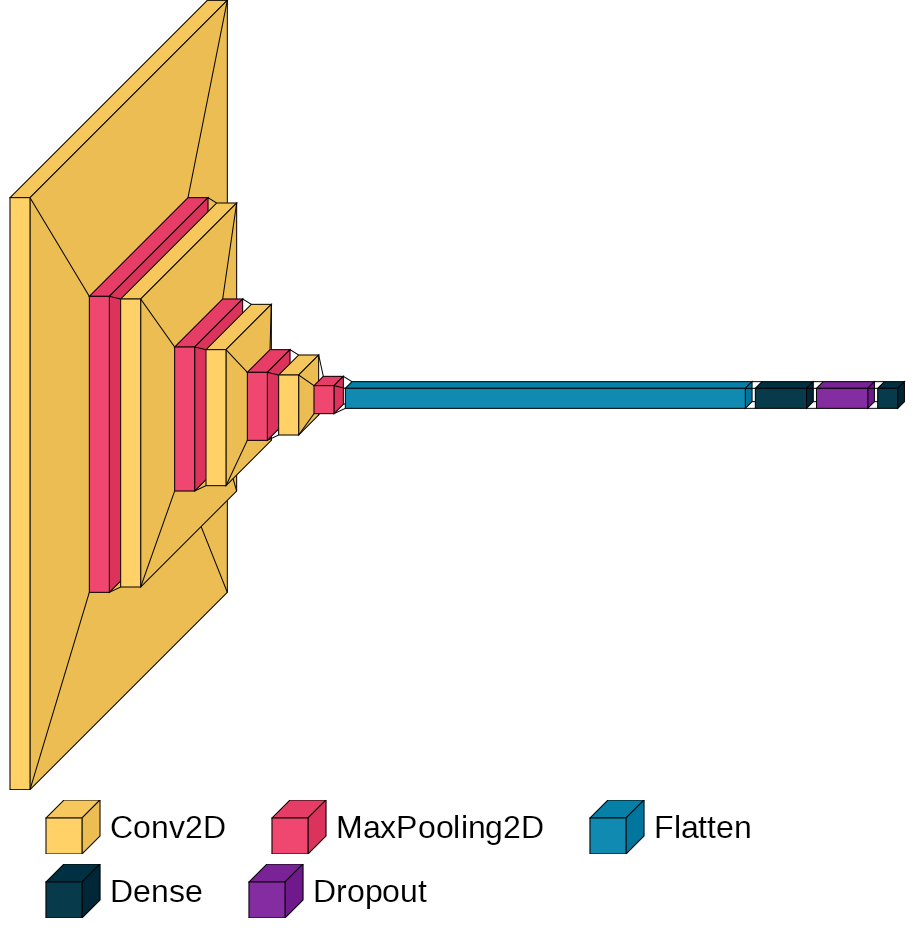

In [ ]:
import visualkeras
num_classes = len(train_generator.class_indices)
model = build_model(num_classes)
from PIL import ImageFont

font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf", 32)  # using comic sans is strictly prohibited!
visualkeras.layered_view(model, legend=True, font=font)  # font is optional!

In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,455,173 (13.18 MB)

 Trainable params: 3,455,173 (13.18 MB)

 Non-trainable params: 0 (0.00 B)

VGG16 Model

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout

def build_vgg16_model(num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

    # Freeze the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers on top of the base model
    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    return model

Found 4419 images belonging to 5 classes.
Found 1102 images belonging to 5 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


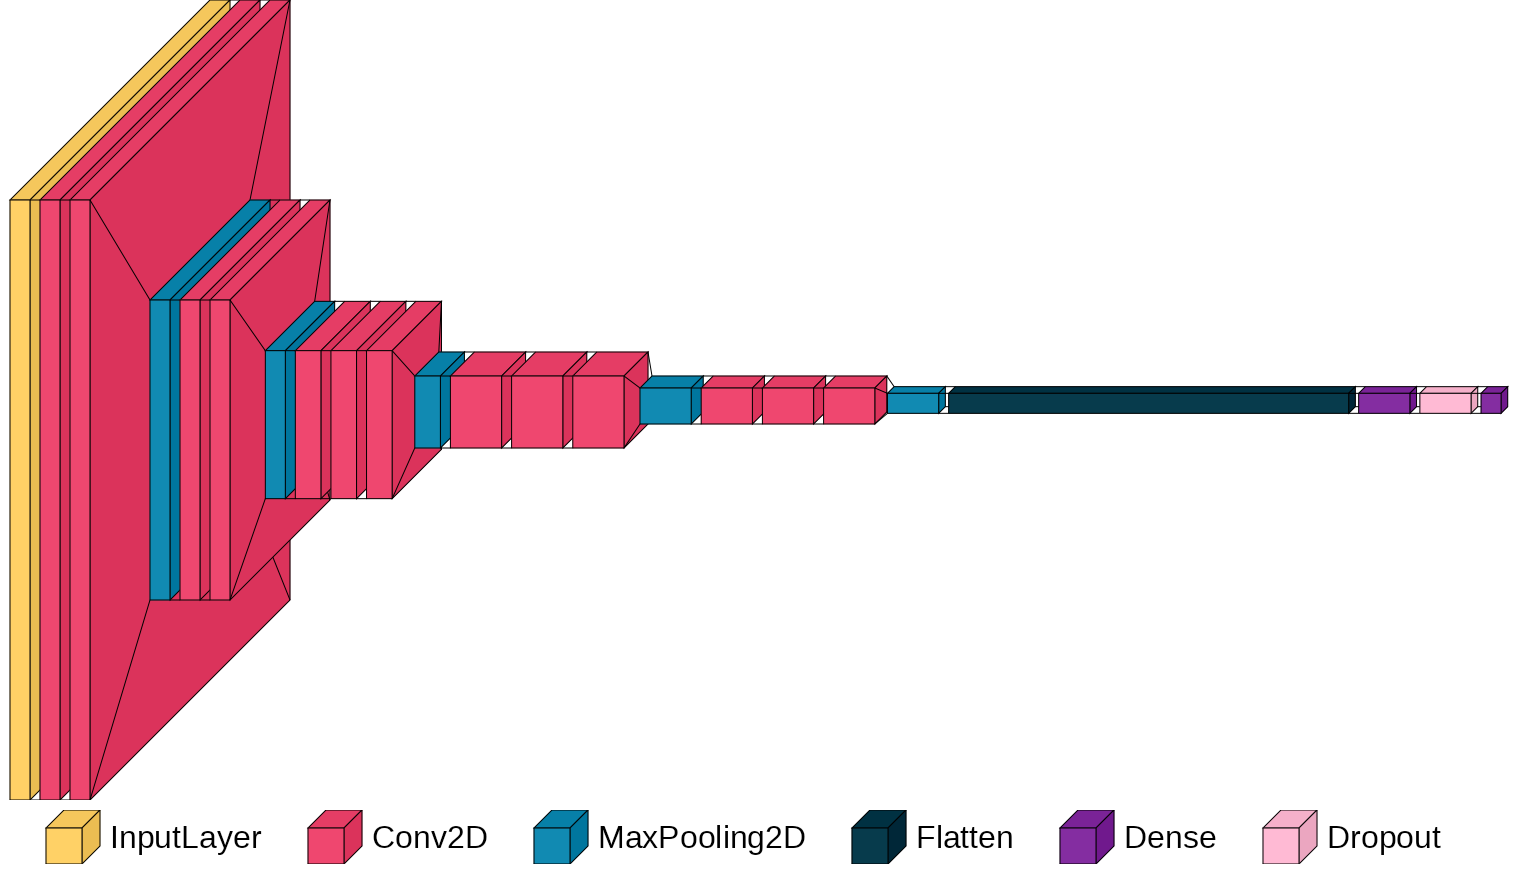

In [ ]:
train_generator, val_generator = create_generators(plant)
num_classes = len(train_generator.class_indices)
model = build_vgg16_model(num_classes)
import visualkeras
from PIL import ImageFont

font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf", 32)  # using comic sans is strictly prohibited!
visualkeras.layered_view(model, legend=True, font=font)  # font is optional!

In [ ]:
plants = ['bean', 'rice', 'wheat']  # List of your plant names

for plant in plants:
    print(f'Training VGG16 model for {plant}...')
    train_generator, val_generator = create_generators(plant)
    num_classes = len(train_generator.class_indices)

    # Train VGG16 model
    vgg16_model = build_vgg16_model(num_classes)
    vgg16_model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_data=val_generator,
        validation_steps=val_generator.samples // val_generator.batch_size,
        epochs=20
    )

    val_loss, val_acc = vgg16_model.evaluate(val_generator)
    print(f'VGG16 - {plant} - Validation accuracy: {val_acc:.2f}')

Training VGG16 model for bean...
Found 1034 images belonging to 3 classes.
Found 133 images belonging to 3 classes.
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 301ms/step - accuracy: 0.4475 - loss: 2.0517 - val_accuracy: 0.7344 - val_loss: 0.6386
Epoch 2/20
 1/32 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.6875 - loss: 0.6626

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.6875 - loss: 0.6626 - val_accuracy: 0.8000 - val_loss: 0.3165
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 245ms/step - accuracy: 0.6934 - loss: 0.7083 - val_accuracy: 0.7578 - val_loss: 0.5542
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6250 - loss: 0.7514 - val_accuracy: 0.8000 - val_loss: 0.4592
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 268ms/step - accuracy: 0.6877 - loss: 0.7274 - val_accuracy: 0.7031 - val_loss: 0.6177
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7500 - loss: 0.7919 - val_accuracy: 0.6000 - val_loss: 0.5723
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 291ms/step - accuracy: 0.6550 - loss: 0.7905 - val_accuracy: 0.7891 - val_loss: 0.5264
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7500 - loss: 0.5804 - val_accuracy: 0.8000 - val_loss: 0.6434
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 239ms/step - accuracy: 0.7295 - loss: 0.6389 - val_accuracy: 0.7500 - val_los

In [ ]:
vgg16_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 27,306,833 (104.17 MB)

 Trainable params: 4,197,381 (16.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 8,394,764 (32.02 MB)

ResNet Model

In [ ]:
from tensorflow.keras.applications import ResNet50

def build_resnet50_model(num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

    # Freeze the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers on top of the base model
    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    return model

Found 4419 images belonging to 5 classes.
Found 1102 images belonging to 5 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


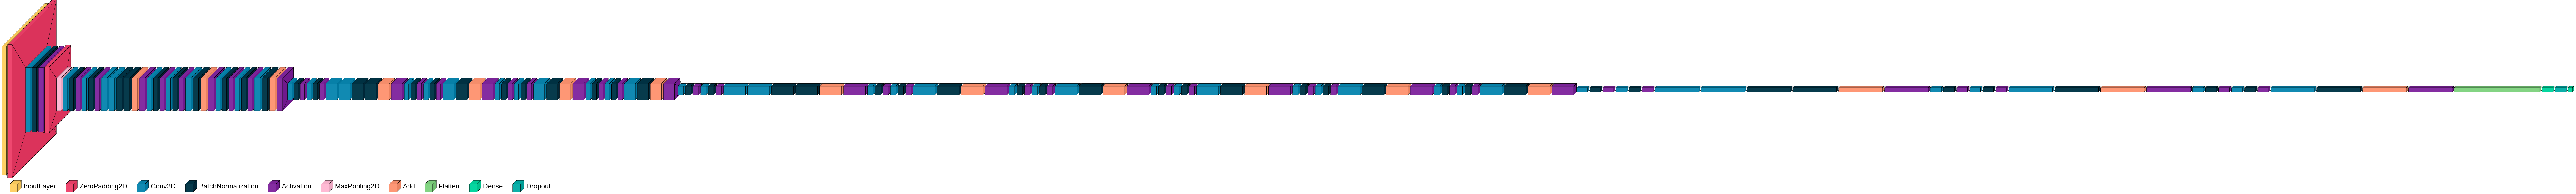

In [ ]:
train_generator, val_generator = create_generators(plant)
num_classes = len(train_generator.class_indices)
model = build_resnet50_model(num_classes)
import visualkeras
from PIL import ImageFont

font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf", 32)  # using comic sans is strictly prohibited!
visualkeras.layered_view(model, legend=True, font=font)  # font is optional!

In [ ]:
plants = ['bean', 'rice', 'wheat']  # List of your plant names

for plant in plants:
    train_generator, val_generator = create_generators(plant)
    num_classes = len(train_generator.class_indices)
    print(f'Training ResNet50 model for {plant}...')

    # Train ResNet50 model
    resnet50_model = build_resnet50_model(num_classes)
    resnet50_model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_data=val_generator,
        validation_steps=val_generator.samples // val_generator.batch_size,
        epochs=20
    )

    val_loss, val_acc = resnet50_model.evaluate(val_generator)
    print(f'ResNet50 - {plant} - Validation accuracy: {val_acc:.2f}')

Training VGG16 model for bean...
Found 1034 images belonging to 3 classes.
Found 133 images belonging to 3 classes.
Training ResNet50 model for bean...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 588ms/step - accuracy: 0.3591 - loss: 4.2263 - val_accuracy: 0.3516 - val_loss: 1.0993
Epoch 2/20
 1/32 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.3125 - loss: 1.1866

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 212ms/step - accuracy: 0.3125 - loss: 1.1866 - val_accuracy: 0.2000 - val_loss: 1.3713
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 262ms/step - accuracy: 0.3717 - loss: 1.1481 - val_accuracy: 0.3359 - val_loss: 1.0964
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3125 - loss: 1.0951 - val_accuracy: 0.4000 - val_loss: 1.0953
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 261ms/step - accuracy: 0.3449 - loss: 1.0973 - val_accuracy: 0.4062 - val_loss: 1.0965
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4062 - loss: 1.0978 - val_accuracy: 0.6000 - val_loss: 1.0854
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 293ms/step - accuracy: 0.3554 - loss: 1.0982 - val_accuracy: 0.3438 - val_loss: 1.0985
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3750 - loss: 1.0984 - val_accuracy: 0.2000 - val_loss: 1.0994
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 232ms/step - accuracy: 0.3263 - loss: 1.0991 - val_accuracy: 0.3125 - val_lo

In [ ]:
resnet50_model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 156, 156, 3)    │              0 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 75, 75, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 75, 75, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 75, 75, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 77, 77, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 38, 38, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 38, 38, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 38, 38, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 38, 38, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 38, 38, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 38, 38, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 38, 38, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 102,240,145 (390.02 MB)

 Trainable params: 26,217,477 (100.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 52,434,956 (200.02 MB)

CrossViT

In [ ]:
!pip install torch torchvision timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 64.0 MB/s eta 0:00:00


In [ ]:
import torch
import timm
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

# Define transformations for training and validation datasets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Function to create data loaders
def create_dataloaders(plant_name):
    train_dir = f'/content/plant_diseases_data/{plant_name}/train'
    val_dir = f'/content/plant_diseases_data/{plant_name}/val'

    train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
    val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms['val'])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    return train_loader, val_loader, len(train_dataset.classes)


In [ ]:
def build_crossvit_model(num_classes):
    model = timm.create_model('crossvit_15_240', pretrained=True, num_classes=num_classes)

    # Optionally freeze layers
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze the classifier head
    for param in model.head.parameters():
        param.requires_grad = True

    return model

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    model = model.to(device)
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')

        model.eval()
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                val_corrects += torch.sum(preds == labels.data)

        val_acc = val_corrects.double() / len(val_loader.dataset)

        if val_acc > best_acc:
            best_acc = val_acc

    print(f'Best Validation Accuracy: {best_acc:.4f}')
    return model

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

plants = ['bean', 'rice', 'wheat']  # List of your plant names

for plant in plants:
    print(f'Training CrossViT model for {plant}...')

    train_loader, val_loader, num_classes = create_dataloaders(plant)
    model = build_crossvit_model(num_classes)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.head.parameters(), lr=1e-4)

    trained_model = train_model(model, train_loader, val_loader, criterion, optimizer)

    print(f'{plant} - Training complete.')

Training CrossViT model for bean...
Epoch 0/19, Loss: 1.0583, Acc: 0.5348
Epoch 1/19, Loss: 1.0104, Acc: 0.6373
Epoch 2/19, Loss: 0.9678, Acc: 0.6857
Epoch 3/19, Loss: 0.9282, Acc: 0.7176
Epoch 4/19, Loss: 0.8936, Acc: 0.7427
Epoch 5/19, Loss: 0.8603, Acc: 0.7476
Epoch 6/19, Loss: 0.8292, Acc: 0.7708
Epoch 7/19, Loss: 0.8021, Acc: 0.7766
Epoch 8/19, Loss: 0.7775, Acc: 0.7882
Epoch 9/19, Loss: 0.7562, Acc: 0.7911
Epoch 10/19, Loss: 0.7324, Acc: 0.8027
Epoch 11/19, Loss: 0.7126, Acc: 0.8114
Epoch 12/19, Loss: 0.6949, Acc: 0.8037
Epoch 13/19, Loss: 0.6763, Acc: 0.8191
Epoch 14/19, Loss: 0.6619, Acc: 0.8172
Epoch 15/19, Loss: 0.6479, Acc: 0.8172
Epoch 16/19, Loss: 0.6320, Acc: 0.8230
Epoch 17/19, Loss: 0.6182, Acc: 0.8259
Epoch 18/19, Loss: 0.6063, Acc: 0.8327
Epoch 19/19, Loss: 0.5939, Acc: 0.8317
Best Validation Accuracy: 0.8496
bean - Training complete.
Training CrossViT model for rice...
Epoch 0/19, Loss: 1.0651, Acc: 0.5104
Epoch 1/19, Loss: 1.0543, Acc: 0.5417
Epoch 2/19, Loss: 1.045

In [ ]:
print(model)

CrossVit(
  (patch_embed): ModuleList(
    (0): PatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(12, 12), stride=(12, 12))
    )
    (1): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    )
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-2): 3 x MultiScaleBlock(
      (blocks): ModuleList(
        (0): Sequential(
          (0): Block(
            (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
            (attn): Attention(
              (qkv): Linear(in_features=192, out_features=576, bias=True)
              (q_norm): Identity()
              (k_norm): Identity()
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=192, out_features=192, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
            )
            (ls1): Identity()
            (drop_path1): Identity()
            (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=Tru

In [ ]:
from PIL import ImageFont

font = ImageFont.truetype("arial.ttf", 32)  # using comic sans is strictly prohibited!
visualkeras.layered_view(model, legend=True, font=font)  # font is optional!